### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/mtsamples.csv'

Mounted at /content/drive


### Loading Dataset





In [4]:
dataframe = pd.read_csv(path)
dataframe.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [5]:
len(dataframe)

4999

### Using important columns



In [10]:
dataframe = dataframe.loc[:,["transcription", "keywords"]]
dataframe.head()

,transcription,keywords
0,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [11]:
dataframe = dataframe.dropna(subset=['transcription', 'keywords'], how='any')

dataframe.shape

(3898, 2)

### Let us see the length of input and output

Max Length :  2008
Min Length :  1


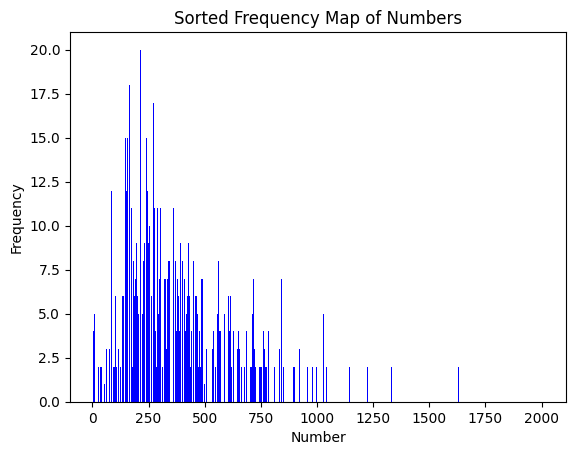

In [14]:
word_lengths = []


for sent in dataframe['transcription']:
    word_lengths.append(len(sent.split()))

print("Max Length : ", max(word_lengths))
print("Min Length : ", min(word_lengths))

from collections import Counter
frequency_map = Counter(word_lengths)

# Sort the values and frequencies in ascending order
sorted_values, sorted_frequencies = zip(*sorted(frequency_map.items()))

# Plotting the sorted frequency map
plt.bar(sorted_values, sorted_frequencies, color='blue')

# Adding labels and title
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Sorted Frequency Map of Numbers')

# Display the plot
plt.show()

Max Length :  118
Min Length :  0


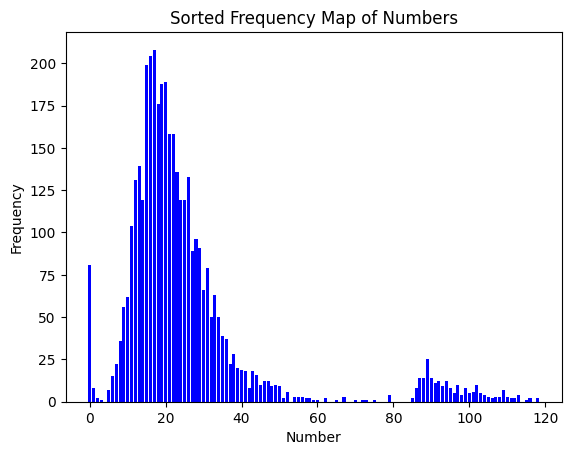

In [15]:
word_lengths = []

for sent in dataframe['keywords']:
    word_lengths.append(len(sent.split()))

print("Max Length : ", max(word_lengths))
print("Min Length : ", min(word_lengths))

from collections import Counter
frequency_map = Counter(word_lengths)

# Sort the values and frequencies in ascending order
sorted_values, sorted_frequencies = zip(*sorted(frequency_map.items()))

# Plotting the sorted frequency map
plt.bar(sorted_values, sorted_frequencies, color='blue')

# Adding labels and title
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Sorted Frequency Map of Numbers')

# Display the plot
plt.show()

In [28]:
!pip install accelerate bitsandbytes -q
from transformers import BartForConditionalGeneration, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base", padding_side="left",
                                         truncation_side='right')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

### Create dataloader

In [ ]:
class MedicalKeywordDataset(Dataset):
    def __init__(self, df, tokenizer, max_length, final_length):
        self.df = df
        self.transcript = df['transcription']
        self.keywords = df['keywords']
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.final_length = final_length

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        transcript_tokens = self.tokenizer(self.transcript.iloc[idx], padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')['input_ids']
        keyword_tokens = self.tokenizer(self.keywords.iloc[idx], padding="max_length", truncation=True, max_length=self.final_length, return_tensors='pt')['input_ids']
        # transcript_tokens = self.tokenizer(self.transcript.iloc[idx], padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        # keyword_tokens = self.tokenizer(self.keywords.iloc[idx], padding="max_length", truncation=True, max_length=self.final_length, return_tensors='pt')

        transcript_tokens = transcript_tokens.to(device)
        keyword_tokens = keyword_tokens.to(device)

        return transcript_tokens, keyword_tokens

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=0.9, random_state=34)

ds_train = MedicalKeywordDataset(train, tokenizer, 1000, 110)
ds_test = MedicalKeywordDataset(test, tokenizer, 1000, 110)

batch_size = 4
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

### Training model


In [47]:
# Using Adam optimizer with a learning rate of 2e-4
optimizer = Adam(model.parameters(), lr=2e-4)

# Defining the number of epochs
epochs = 3

def calculate_batches(total, batch_size):
    return total // batch_size if total % batch_size == 0 else total // batch_size + 1

# Calculate the number of batches for training and testing datasets
train_batches = calculate_batches(dl_train.shape[0], batch_size)
test_batches = calculate_batches(dl_test.shape[0], batch_size)

model.train()
training_loss = 0
training_accuracy = 0

# Training loop
for epoch in range(epochs):
    for inputs, labels in dl_train:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, labels=labels)

        # Loss computation
        current_loss = outputs.loss
        training_loss += current_loss.item()

        # Accuracy computation
        logits = outputs.logits
        predictions = torch.argmax(torch.softmax(logits, dim=2), dim=2)
        accuracy = torch.sum(labels == predictions).item() / (labels.shape[0] * labels.shape[1])
        training_accuracy += accuracy

        # Backpropagation
        current_loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}: Loss={training_loss/train_batches:.4f} Accuracy={training_accuracy/train_batches:.4f}")

    model.eval()
    testing_loss = 0
    testing_accuracy = 0

    # Testing loop
    with torch.no_grad():
        for inputs, labels in dl_test:
            # Forward pass
            outputs = model(inputs, labels=labels)

            # Loss computation
            current_loss = outputs.loss
            testing_loss += current_loss.item()

            # Accuracy computation
            logits = outputs.logits
            predictions = torch.argmax(torch.softmax(logits, dim=2), dim=2)
            accuracy = torch.sum(labels == predictions).item() / (labels.shape[0] * labels.shape[1])
            testing_accuracy += accuracy

    print(f"Testing: Loss={testing_loss/test_batches:.4f} Accuracy={testing_accuracy/test_batches:.4f}")


Epoch 1/3: Loss=1.2154 Accuracy=0.7956
Testing: Loss=0.8033 Accuracy=0.8390
Epoch 2/3: Loss=0.9356 Accuracy=0.8191
Testing: Loss=0.7253 Accuracy=0.8462
Epoch 3/3: Loss=0.6454 Accuracy=0.8552
Testing: Loss=0.6711 Accuracy=0.8540


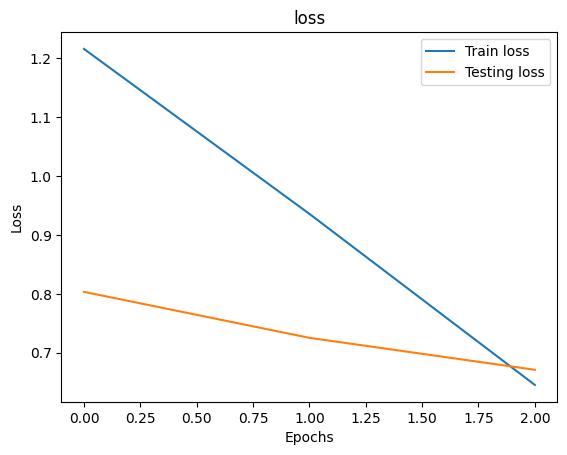

In [9]:
import matplotlib.pyplot as plt
data1 = [1.2154, 0.9356, 0.6454]
data2 = [0.8033, 0.7253, 0.6711]
plt.plot(data1, label='Line 1')

# Plot the second line
plt.plot(data2, label='Line 2')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('loss')
plt.legend(['Train loss', 'Testing loss'])

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
data = [1.2154, 0.9356, 0.6454]
plt.plot(data)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')

# Show the plot
plt.show()

In [38]:
path1 = '/content/drive/My Drive/model_n1.pth'

In [40]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, path1)


### Final Predictions

In [17]:
import torch

def generate_keywords(input, model, tokenizer):
    input = tokenizer(input, max_length=1000, padding='max_length', truncation=True,  return_tensors='pt')['input_ids']
    input = input.to(device)
    input = model.generate(input, min_length=20, max_length=120)
    output = tokenizer.batch_decode(input, skip_special_tokens=True)
    return output


In [44]:
for i in range(4):
    print("Transcription :", dataframe['transcription'].iloc[i])
    print("Keywords :", dataframe['keywords'].iloc[i])
    print("Result :", generate_keywords(dataframe['transcription'].iloc[i], model, tokenizer))
    print("="*80)

Transcription : TITLE OF OPERATION: , Phacoemulsification with posterior chamber intraocular lens implant in the right eye.,INDICATION FOR SURGERY: , The patient is a 27-year-old male who sustained an open globe injury as a child.  He subsequently developed a retinal detachment in 2005 and now has silicone oil in the anterior chamber of the right eye as well as a dense cataract.  He is undergoing silicone oil removal as well as concurrent cataract extraction with lens implant in the right eye.,PREOP DIAGNOSIS:,1.  History of open globe to the right eye.,2.  History of retinal detachment status post repair in the right eye.,3.  Silicone oil in anterior chamber.,4.  Dense silicone oil cataract in the right eye obscuring the view of the posterior pole.,POSTOP DIAGNOSIS:,1.  History of open globe to the right eye.,2.  History of retinal detachment status post repair in the right eye.,3.  Silicone oil in anterior chamber.,4.  Dense silicone oil cataract in the right eye obscuring the view o

In [1]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
import nltk

# Download NLTK data
nltk.download("punkt")

def calculate_rouge(reference, candidate):
    # Tokenize the sentences
    reference = nltk.word_tokenize(reference.lower())
    candidate = nltk.word_tokenize(candidate.lower())

    # Calculate ROUGE scores
    smoothing_function = SmoothingFunction().method1
    rouge_scores = corpus_bleu([reference], [candidate], smoothing_function=smoothing_function)

    return rouge_scores

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# i = 11
# print(df['keywords'].iloc[i])
# print(" ".join(generate_keywords(df['transcription'].iloc[i])))
pred = "surgery, ischemic cardiomyopathy, coronary artery bypass, cardiopulmonary balloon, intraaortic balloon, running sternotomy incision, common femoral vein, ascending aorta, descending vena cava, descending descending, vena, cavaNOTE,: Thesetranscribed medical transcription sample reports and examples are provided by various users andare for reference purpose only. MTHelpLine does not certify accuracy and quality of sample reports"
ground = "surgery, cardiomyopathy, ioban, ischemic, ischemic cardiomyopathy, mahurkar catheter, orthostatic, seldinger, swan-ganz, allograft, aorta, balloon, cardiac, cardiopulmonary bypass, catheter, coagulopathy, coronary artery bypass, femoral vein, hemofiltration, intraaortic, intraaortic balloon, sternotomy, transplantation, ventricle, inferior vena cava, cardiac allograft, common femoral, vena cava, pulmonary artery, atrium, insertion, cardiopulmonary, artery"
rouge_scores = calculate_rouge(ground, pred)
print("ROUGE Scores:", rouge_scores)

ROUGE Scores: 0.1327574366655649983


In [4]:
score = 0
for i in range(100):
    ground =  dataframe['keywords'].iloc[i]
    pred = generate_keywords(dataframe['transcription'].iloc[i], model, tokenizer)
    score += calculate_rouge(ground, pred)

print(score/100)

0.15275563525544397